In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.naive_bayes import GaussianNB
import random

In [46]:
### !!! VERY CONSUMING OPERATION !!! ###

# Path to the directory containing the CSV files
path = "TON_IOT_Datasets/Processed_Network_dataset/"

# Define the target number of rows
target_row_count = 5_000_000
rows_per_file = target_row_count // 23

# Use glob to get all file paths matching the pattern
all_files = glob.glob(path + "Network_dataset_*.csv")

# Initialize an empty list to store sampled DataFrames
sampled_dfs = []

# Loop through each file, read it in its entirety, and sample rows
for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    sampled_df = df.sample(n=min(len(df), rows_per_file), random_state=42)
    sampled_dfs.append(sampled_df)

# Concatenate all sampled DataFrames into one
combined_df = pd.concat(sampled_dfs, ignore_index=True)

# Adjust the sample size if combined_df has fewer rows than target_row_count
final_sample_size = min(len(combined_df), target_row_count)

# Randomly shuffle and limit rows to final_sample_size
final_df = combined_df.sample(n=final_sample_size, random_state=42).reset_index(drop=True)
df = final_df

df.head()

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type,uid
0,1556029027,192.168.1.31,53386,192.168.35.151,443,tcp,-,0.000000,0,0,...,0,-,-,-,-,-,-,1,scanning,NaN
1,1556027221,192.168.1.30,53241,192.168.1.180,63606,tcp,-,0.000000,0,0,...,0,-,-,-,-,-,-,1,scanning,NaN
2,1556238678,192.168.1.30,48844,192.168.1.184,80,tcp,http,0.006884,175,171,...,0,-,-,-,-,-,-,1,ddos,NaN
3,1556263694,192.168.1.38,41894,192.168.1.152,80,tcp,-,39.893225,0,0,...,0,-,-,-,-,-,-,1,ddos,NaN
4,1556133212,192.168.1.30,438,192.168.1.184,438,tcp,-,0.000001,0,0,...,0,-,-,-,-,-,-,1,dos,NaN


In [47]:
# Display the distribution of attack types in the final dataset
df['type'].value_counts()

type
scanning      1552228
ddos          1340172
dos            733790
xss            458530
password       373434
backdoor       239504
normal         187326
injection       98449
ransomware      15887
mitm              673
Name: count, dtype: int64

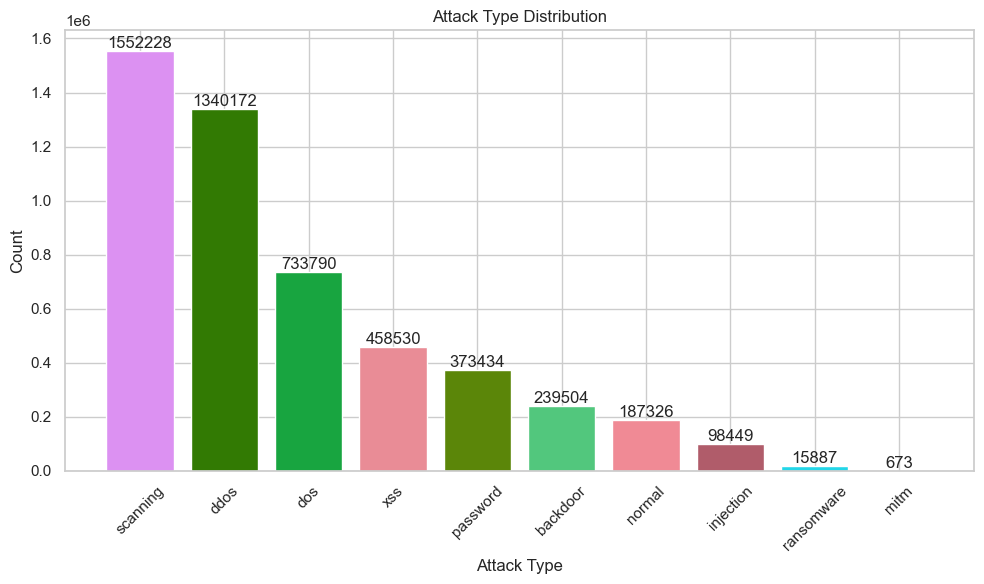

In [48]:
# Count the occurrences of each attack type
attack_counts = df['type'].value_counts()

# Generate a list of random colors for the bars
colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(attack_counts))]

# Generate the plot for attack type distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(attack_counts.index, attack_counts.values, color=colors)
plt.title("Attack Type Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{height}', 
        ha='center', 
        va='bottom'
    )

plt.tight_layout()

# Show the plot
plt.show()

In [49]:
# Check for null values in the features
df.isnull().sum()

ts                              0
src_ip                          0
src_port                        0
dst_ip                          0
dst_port                        0
proto                           0
service                         0
duration                        0
src_bytes                       0
dst_bytes                       0
conn_state                      0
missed_bytes                    0
src_pkts                        0
src_ip_bytes                    0
dst_pkts                        0
dst_ip_bytes                    0
dns_query                       0
dns_qclass                      0
dns_qtype                       0
dns_rcode                       0
dns_AA                          0
dns_RD                          0
dns_RA                          0
dns_rejected                    0
ssl_version                     0
ssl_cipher                      0
ssl_resumed                     0
ssl_established                 0
ssl_subject                     0
ssl_issuer    

In [50]:
# Drop UID column since it has null values
df.drop('uid', axis=1, inplace=True)

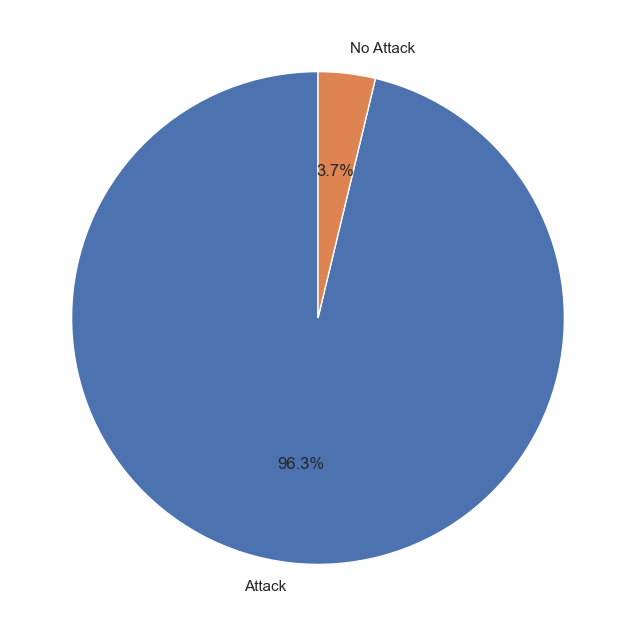

In [51]:
# Create pie chart which shows the percentage of attacks
attack_counts = df['label'].value_counts()
attack_counts.plot(kind='pie', 
                   labels=attack_counts.index.map({0: 'No Attack', 1: 'Attack'}), 
                   autopct='%1.1f%%', 
                   startangle=90, 
                   figsize=(8, 8))

# Show the plot
plt.ylabel('')  # Remove the y-axis label
plt.show()

In [52]:
# Show the types of each column
df.dtypes

ts                          int64
src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                  object
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
ssl_subject                object
ssl_issuer    

In [53]:
label_encoder = LabelEncoder()
label_mappings = {}

# Apply label encoding to each non-numeric column and store mappings
for column in df.select_dtypes(include=['object']).columns:
    # Convert the column to string type to avoid mixed types
    df[column] = df[column].astype(str)
    
    df.loc[:, column] = label_encoder.fit_transform(df[column])

    # Convert the encoded column to integer type explicitly
    df[column] = df[column].astype(int)
    
    # Store the mapping of label to encoded value for the column
    label_mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for column, mapping in label_mappings.items():
    print(f"{column}: {dict(list(mapping.items())[:5])}")

src_ip: {'0': 0, '0.0.0.0': 1, '0.105.134.68': 2, '0.11.129.89': 3, '0.130.71.43': 4}
dst_ip: {'101.119.11.10': 0, '101.119.11.11': 1, '101.119.11.16': 2, '101.119.11.17': 3, '101.119.11.19': 4}
proto: {'icmp': 0, 'tcp': 1, 'udp': 2}
service: {'-': 0, 'dce_rpc': 1, 'dce_rpc;gssapi;smb;ntlm': 2, 'dce_rpc;ntlm': 3, 'dhcp': 4}
src_bytes: {'0': 0, '0.0.0.0': 1, '1': 2, '10': 3, '100': 4}
conn_state: {'OTH': 0, 'REJ': 1, 'RSTO': 2, 'RSTOS0': 3, 'RSTR': 4}
dns_query: {'(empty)': 0, '*\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00': 1, '-': 2, '../nessus': 3, '0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.ip6.arpa': 4}
dns_AA: {'-': 0, 'F': 1, 'T': 2}
dns_RD: {'-': 0, 'F': 1, 'T': 2}
dns_RA: {'-': 0, 'F': 1, 'T': 2}
dns_rejected: {'-': 0, 'F': 1, 'T': 2}
ssl_version: {'-': 0, 'TLSv10': 1, 'TLSv11': 2, 'TLSv12': 3, 'TLSv13': 4}
ssl_cipher: {'-': 0, 'TLS_AES_128_GCM_SHA256': 1, 'TLS_DHE_RSA_WITH_AES_128_CBC_SHA': 2, 'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA25

In [54]:
# Print the mapping specifically for the 'type' column
print("Type column mappings:", label_mappings.get('type', 'No mapping found for type'))

Type column mappings: {'backdoor': 0, 'ddos': 1, 'dos': 2, 'injection': 3, 'mitm': 4, 'normal': 5, 'password': 6, 'ransomware': 7, 'scanning': 8, 'xss': 9}


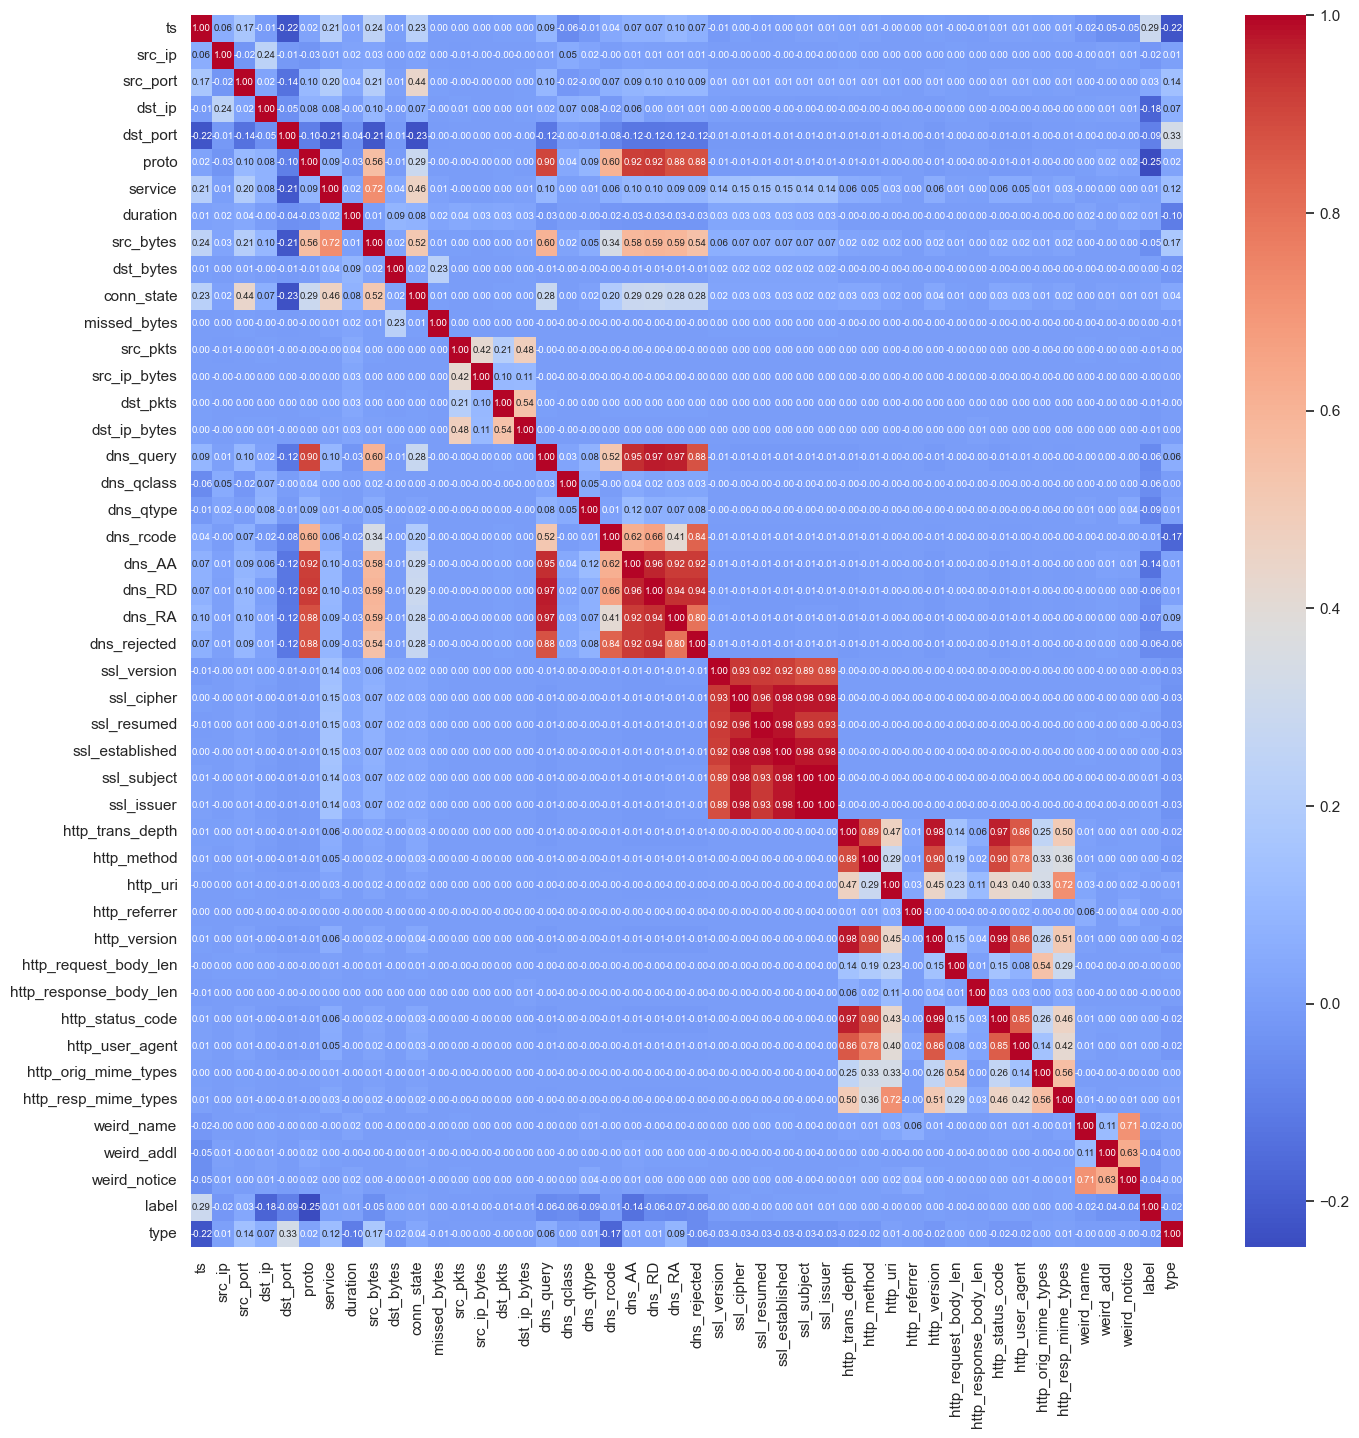

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove columns with only one unique value and create a copy
df = df.loc[:, df.nunique() > 1].copy()

# Calculate the correlation matrix
corr = df.corr()

# Visualize the correlation matrix with improved readability
plt.figure(figsize=(16, 16))  # Set a large figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 7})

# Show the plot
plt.show()

In [56]:
# Identify and drop highly correlated features
# Set a threshold for correlation
threshold = 0.80
to_drop = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            colname = corr.columns[i]
            to_drop.add(colname)

# Drop the correlated features
df = df.drop(columns=to_drop)

df.head()

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_referrer,http_request_body_len,http_response_body_len,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,1556029027,2084,53386,1197,443,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,8
1,1556027221,2083,53241,1122,63606,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,8
2,1556238678,2083,48844,1123,80,1,13,0.006884,3829,171,...,0,0,0,0,0,0,0,0,1,1
3,1556263694,2091,41894,1120,80,1,0,39.893225,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1556133212,2083,438,1123,438,1,0,0.000001,0,0,...,0,0,0,0,0,0,0,0,1,2


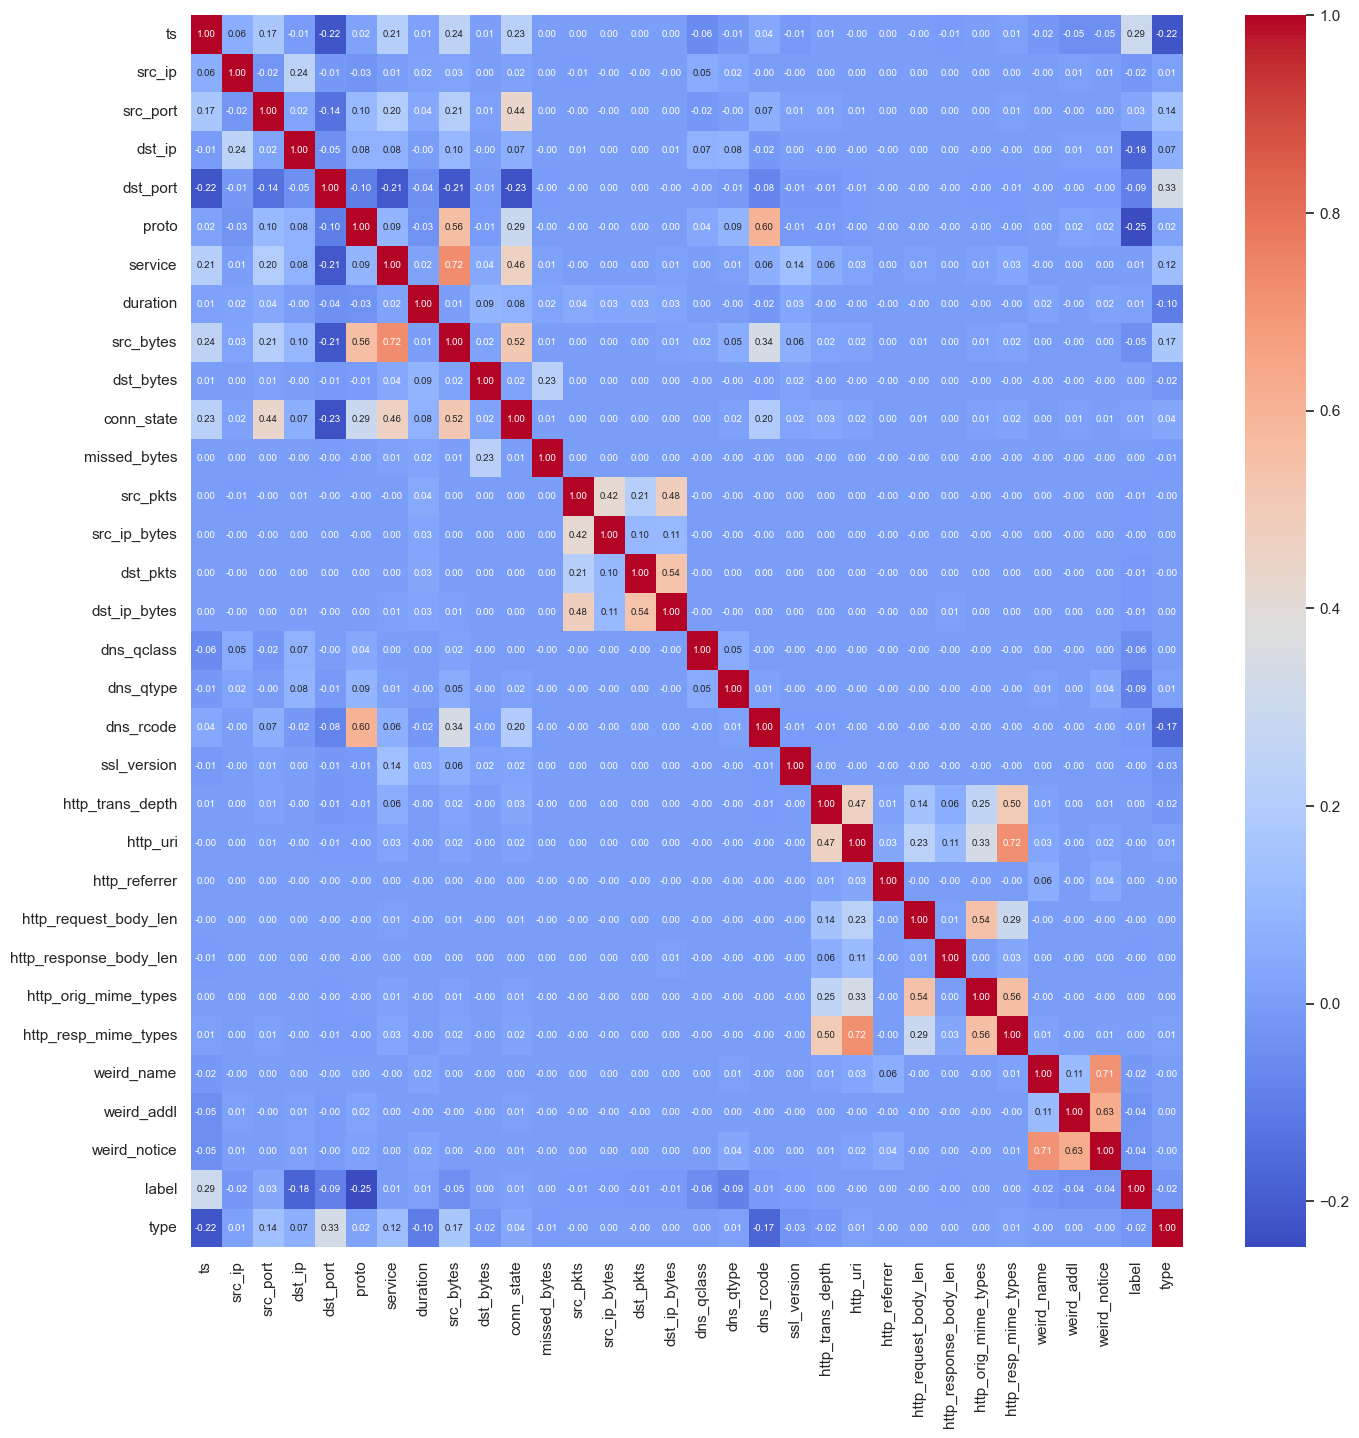

In [57]:
# Calculate correlation matrix again after the reduction
corr = df.corr()

# Visualize the correlation matrix with improved readability
plt.figure(figsize=(16, 16))  # Set a large figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 7})

# Show the plot
plt.show()

In [58]:
# Remove the attack type column
features = df.drop(['type', 'label'], axis=1)  

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA without specifying n_components
pca = PCA()
pca.fit(scaled_features)

# Calculate cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

print(f'Explained variance by each component: {pca.explained_variance_ratio_}')

# Set the variance threshold 
threshold = 0.90
n_components = np.argmax(explained_variance >= threshold) + 1

print(f"Number of components to retain {threshold*100}% variance: {n_components}")

# Perform PCA again with the chosen number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, 
                      columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['type'] = df['type'].values
pca_df['label'] = df['label'].values

Explained variance by each component: [0.09797558 0.08862053 0.0671002  0.06564972 0.04908796 0.04311613
 0.04146007 0.03735406 0.03604518 0.0355761  0.03363115 0.03345369
 0.03284804 0.03209275 0.03186484 0.03101093 0.02926911 0.02876811
 0.02670311 0.02540463 0.02339074 0.02077004 0.01921442 0.0152833
 0.01497175 0.01375297 0.01100979 0.00703899 0.00398277 0.00355335]
Number of components to retain 90.0% variance: 22


In [59]:
df = pca_df;
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,type,label
0,-0.423910,0.062535,0.016654,-0.008065,-0.184448,-0.012757,-0.075552,0.050250,0.016325,-0.274597,...,-0.209693,0.438676,0.081018,0.711769,-0.607233,0.098935,-0.457507,-0.000515,8,1
1,-1.460294,0.288106,0.042626,-0.003210,0.771379,-0.155726,0.226645,-0.164503,-0.014168,0.801712,...,-0.736342,2.882884,-1.069425,-0.610932,1.858033,-0.071417,0.840795,-0.020050,8,1
2,1.525688,-0.322700,-0.074427,-0.006303,-1.162881,-0.170211,-0.288731,-0.000385,-0.025781,0.331928,...,-0.264334,0.164427,-0.008204,-0.433397,-0.079338,-0.053725,-0.458101,-0.002259,1,1
3,-0.004354,-0.029072,-0.048804,0.030986,-0.598631,-0.154314,-0.077811,0.131250,0.047197,-0.573195,...,0.071631,-0.135004,0.114290,0.449262,0.026904,-0.043888,-0.044894,-0.004927,1,1
4,-1.613158,0.317531,-0.002256,0.004509,0.533277,0.225340,0.116433,-0.051236,-0.023480,0.211564,...,0.470277,-1.417953,0.337252,-0.531975,-0.372480,-0.053446,-0.081461,0.007727,2,1


In [60]:
# Bogdan analysis
df = df.dropna()

# Filter the DataFrame to include only rows where 'type' column is 0 (backdoor) or 5 (normal)
filtered_df = df[(df['type'] == 0) | (df['type'] == 5)]

X_df = filtered_df.drop(columns=['label', 'type'])
Y_df = filtered_df['label']

X_df.head()
#Y_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
19,-0.517495,0.070549,-0.152659,0.011782,-0.660620,-0.299142,-0.307366,0.182918,-0.017624,-0.832845,...,-0.221188,0.108584,0.109804,-0.071204,-0.141717,1.000495,0.805152,0.150073,1.018977,0.013151
27,-0.513725,0.069707,-0.153054,0.011791,-0.664540,-0.300839,-0.308711,0.183682,-0.017577,-0.836320,...,-0.221646,0.108768,0.108513,-0.067045,-0.142821,1.006107,0.807464,0.150807,1.020973,0.013159
43,-3.121327,0.674885,0.615373,-0.057304,2.833986,0.397399,1.078764,-0.588967,0.064807,2.555436,...,0.791479,-0.378800,-1.244863,2.749055,0.314598,-0.585683,-4.146604,-0.031848,-4.769465,-0.044669
67,2.721600,-0.711255,0.161964,-0.091663,1.516158,0.361508,0.184406,-0.024112,0.036421,-0.001781,...,0.082684,-0.019662,-0.217263,0.857179,0.006593,0.189017,-1.013103,0.061908,-0.043865,0.017197
76,-2.136601,0.424682,-0.077323,0.017056,0.811526,0.197906,0.164129,-0.111259,-0.057739,0.555011,...,-0.041408,-0.015467,0.203964,0.311602,-0.671658,-1.237465,2.193517,-0.136532,1.771474,0.001787


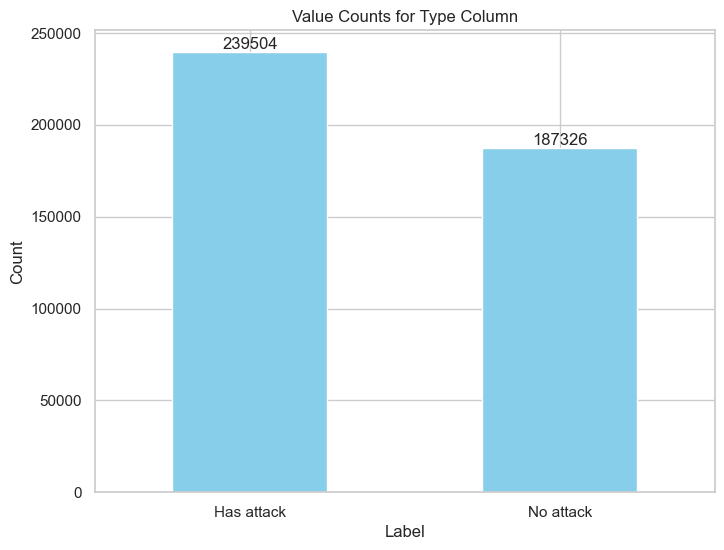

In [61]:
# Get the value counts for the 'label' column
type_counts = Y_df.value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
ax = type_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts for Type Column')
plt.xlabel('Label')
plt.ylabel('Count')

# Set custom labels
ax.set_xticklabels(['Has attack', 'No attack'], rotation=0)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

In [62]:
filtered_df.dtypes

PC1      float64
PC2      float64
PC3      float64
PC4      float64
PC5      float64
PC6      float64
PC7      float64
PC8      float64
PC9      float64
PC10     float64
PC11     float64
PC12     float64
PC13     float64
PC14     float64
PC15     float64
PC16     float64
PC17     float64
PC18     float64
PC19     float64
PC20     float64
PC21     float64
PC22     float64
type       int64
label      int64
dtype: object

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Initialize models
rf = RandomForestClassifier(random_state=39, 
                            class_weight='balanced', 
                            n_estimators=5, 
                            max_depth=3, 
                            max_features='log2', 
                            min_samples_split=40,
                            min_samples_leaf=20,
                            max_leaf_nodes=2,
                            bootstrap=True,
                            max_samples=0.5)

lgbm = LGBMClassifier(random_state=39,
                        n_estimators=30,
                        learning_rate=0.01,
                        max_depth=4,
                        num_leaves=2,
                        min_data_in_leaf=50,
                        feature_fraction=0.8,
                        bagging_fraction=0.8,
                        bagging_freq=5,
                        lambda_l1=1.0,
                        lambda_l2=1.0,
                         verbose=-1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.3 MB/s eta 0:00:00a 0:00:01


In [65]:
from sklearn.model_selection import StratifiedKFold

# Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    return {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity (Recall)': recall,
        'Specificity': specificity
    }

# Cross-validation setup for Random Forest
kf = StratifiedKFold(n_splits=5)
rf_metrics = []

print("Random Forest Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X_df, Y_df), start=1):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold  # Add fold number
    rf_metrics.append(metrics)

# Display results for Random Forest
rf_results_df = pd.DataFrame(rf_metrics)
print(rf_results_df)
print("Mean Results for Random Forest:")
print(rf_results_df.mean(numeric_only=True))

Random Forest Cross-Validation Results:
      TP     TN    FP    FN  Accuracy  Precision  Sensitivity (Recall)  \
0  45878  34662  2803  2023  0.943467   0.942421              0.957767   
1  45954  34579  2886  1947  0.943385   0.940909              0.959354   
2  46018  34506  2959  1883  0.943280   0.939584              0.960690   
3  46023  34583  2882  1878  0.944240   0.941069              0.960794   
4  45908  34580  2886  1992  0.942858   0.940853              0.958413   

   Specificity  Fold  
0     0.925184     1  
1     0.922968     2  
2     0.921020     3  
3     0.923075     4  
4     0.922970     5  
Mean Results for Random Forest:
TP                      45956.200000
TN                      34582.000000
FP                       2883.200000
FN                       1944.600000
Accuracy                    0.943446
Precision                   0.940967
Sensitivity (Recall)        0.959404
Specificity                 0.923043
Fold                        3.000000
dtype: float

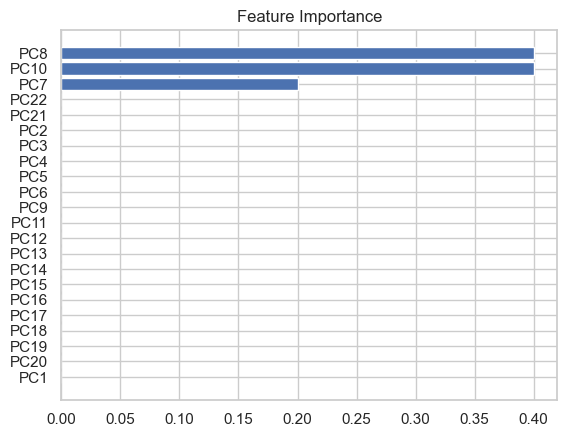

In [66]:
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_df.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [67]:
# Cross-validation setup for LGBM
kf = StratifiedKFold(n_splits=5)
lgbm_metrics = []

print("\nLGBM Cross-Validation Results:")
for fold, (train_index, test_index) in enumerate(kf.split(X_df, Y_df), start=1):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]
    
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    metrics['Fold'] = fold  # Add fold number
    lgbm_metrics.append(metrics)

# Display results for lgbm
lgbm_results_df = pd.DataFrame(lgbm_metrics)
print(lgbm_results_df)
print("Mean Results for LGBM:")
print(lgbm_results_df.mean(numeric_only=True))


LGBM Cross-Validation Results:
      TP     TN    FP   FN  Accuracy  Precision  Sensitivity (Recall)  \
0  47489  30576  6889  412  0.914474   0.873313              0.991399   
1  47553  30627  6838  348  0.915821   0.874281              0.992735   
2  47509  30368  7097  392  0.912272   0.870033              0.991816   
3  47481  30561  6904  420  0.914205   0.873053              0.991232   
4  47433  30694  6772  467  0.915200   0.875067              0.990251   

   Specificity  Fold  
0     0.816122     1  
1     0.817483     2  
2     0.810570     3  
3     0.815721     4  
4     0.819249     5  
Mean Results for LGBM:
TP                      47493.000000
TN                      30565.200000
FP                       6900.000000
FN                        407.800000
Accuracy                    0.914394
Precision                   0.873149
Sensitivity (Recall)        0.991487
Specificity                 0.815829
Fold                        3.000000
dtype: float64


In [78]:
# TOSHKO
df = df.dropna()

filtered_df = df[(df['type'] == 3) | (df['type'] == 5)]

# Prepare features (X) and target (y)
X = filtered_df.drop(columns=['label', 'type'])  # Drop non-feature columns
y = filtered_df['label']  # Target variable is 'label'

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize StratifiedKFold with 5 splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Initialize lists to store metrics
precision_list = []
accuracy_list = []
sensitivity_list = []
tp_list, tn_list, fp_list, fn_list = [], [], [], []

# Perform cross-validation
for run_index, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y), start=1):  # Use enumerate to track the run index
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Initialize and train Logistic Regression model
    model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=50)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Append confusion matrix components
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)  # Sensitivity = Recall
    
    # Append metrics to lists
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    sensitivity_list.append(sensitivity)
    
    # Print results for the current run
    print(f"=== RUN NUMBER {run_index} ===")  # Display the current run index
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity (Recall): {sensitivity:.2f}")
    print()


# Calculate average metrics
avg_precision = sum(precision_list) / len(precision_list)
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_sensitivity = sum(sensitivity_list) / len(sensitivity_list)
avg_tp = sum(tp_list) / len(tp_list)
avg_tn = sum(tn_list) / len(tn_list)
avg_fp = sum(fp_list) / len(fp_list)
avg_fn = sum(fn_list) / len(fn_list)

print("=== Cross-Validation Results (5-Fold) ===")
print(f"Average True Positives (TP): {avg_tp:.2f}")
print(f"Average True Negatives (TN): {avg_tn:.2f}")
print(f"Average False Positives (FP): {avg_fp:.2f}")
print(f"Average False Negatives (FN): {avg_fn:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.2f}")

=== RUN NUMBER 1 ===
True Positives (TP): 18460
True Negatives (TN): 36516
False Positives (FP): 949
False Negatives (FN): 1230
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 2 ===
True Positives (TP): 18407
True Negatives (TN): 36587
False Positives (FP): 878
False Negatives (FN): 1283
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.93

=== RUN NUMBER 3 ===
True Positives (TP): 18388
True Negatives (TN): 36582
False Positives (FP): 883
False Negatives (FN): 1302
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.93

=== RUN NUMBER 4 ===
True Positives (TP): 18462
True Negatives (TN): 36551
False Positives (FP): 914
False Negatives (FN): 1228
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 5 ===
True Positives (TP): 18466
True Negatives (TN): 36569
False Positives (FP): 897
False Negatives (FN): 1223
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== Cross-Validation Results (5-Fold) ===
Average True Positives 

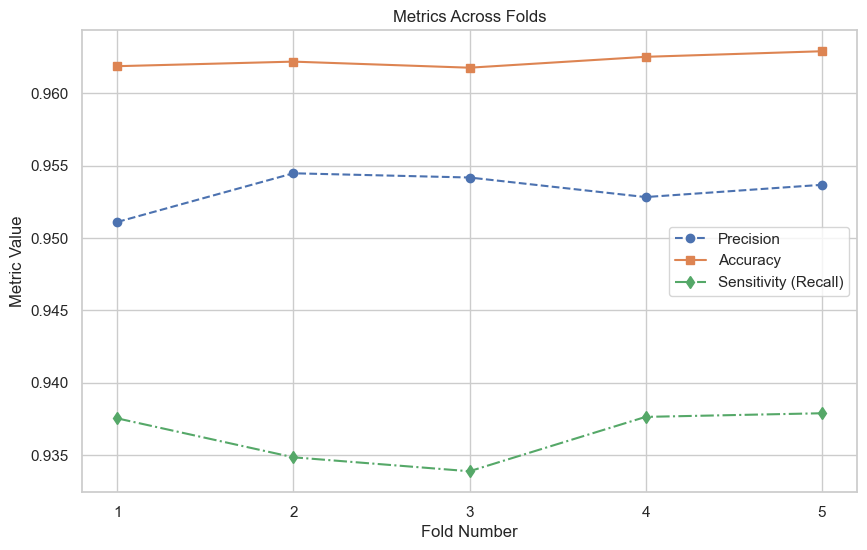

In [79]:
# Line Plot for Metrics Across Folds
folds = np.arange(1, 6)
plt.figure(figsize=(10, 6))
plt.plot(folds, precision_list, marker='o', label='Precision', linestyle='--')
plt.plot(folds, accuracy_list, marker='s', label='Accuracy', linestyle='-')
plt.plot(folds, sensitivity_list, marker='d', label='Sensitivity (Recall)', linestyle='-.')
plt.title("Metrics Across Folds")
plt.xlabel("Fold Number")
plt.ylabel("Metric Value")
plt.xticks(folds)
plt.legend()
plt.show()

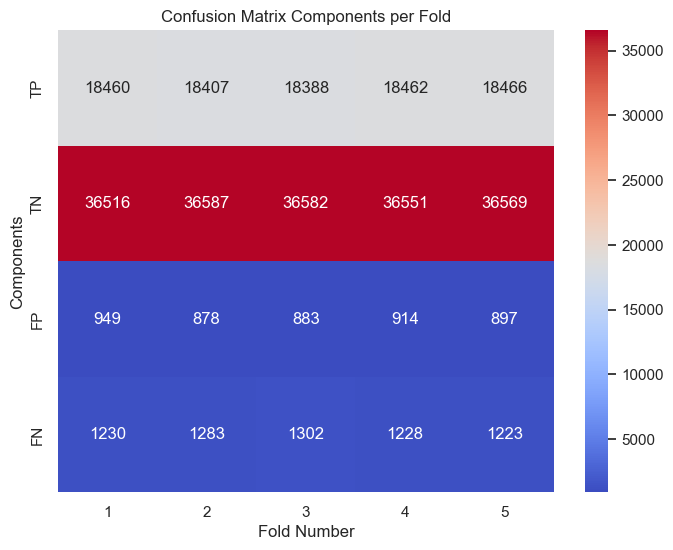

In [80]:
confusion_matrix_data = {
    'Fold': np.arange(1, 6),
    'TP': tp_list,
    'TN': tn_list,
    'FP': fp_list,
    'FN': fn_list
}

confusion_df = pd.DataFrame(confusion_matrix_data).set_index('Fold')

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df.T, annot=True, fmt=".0f", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix Components per Fold")
plt.ylabel("Components")
plt.xlabel("Fold Number")
plt.show()


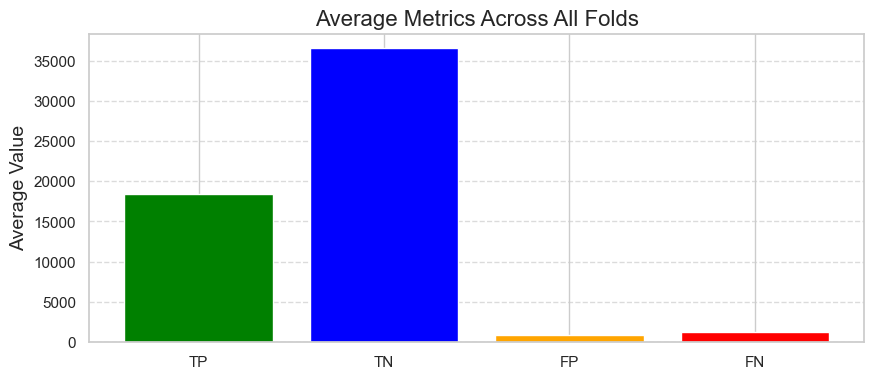

In [81]:
# Number of folds
folds = np.arange(1, 6)  # For 5 folds

# Create a dictionary of results for easier visualization
results = {
    "TP": tp_list,
    "TN": tn_list,
    "FP": fp_list,
    "FN": fn_list,
}

# Bar plot for average metrics
avg_metrics = [avg_tp, avg_tn, avg_fp, avg_fn]
metric_names = ["TP", "TN", "FP", "FN"]

plt.figure(figsize=(10, 4))
plt.bar(metric_names, avg_metrics, color=['green', 'blue', 'orange', 'red'])
plt.title("Average Metrics Across All Folds", fontsize=16)
plt.ylabel("Average Value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [82]:
from sklearn.tree import DecisionTreeClassifier

df = df.dropna()

filtered_df = df[(df['type'] == 3) | (df['type'] == 5)]

# Prepare features (X) and target (y)
X = filtered_df.drop(columns=['label', 'type'])  # Drop non-feature columns
y = filtered_df['label']  # Target variable is 'label'

model = DecisionTreeClassifier(random_state=50)

# Initialize Stratified K-Fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Initialize lists to store metrics
tp_list, tn_list, fp_list, fn_list = [], [], [], []
precision_list, accuracy_list, sensitivity_list = [], [], []

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    print(f"=== Fold {fold} ===")
    
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the Decision Tree model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Compute metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)  # Sensitivity is Recall
    
    # Store metrics for this fold
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    sensitivity_list.append(sensitivity)
    
    # Print results for this fold
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.5f}")
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Sensitivity (Recall): {sensitivity:.5f}")
    print()


avg_tp = sum(tp_list) / len(tp_list)
avg_tn = sum(tn_list) / len(tn_list)
avg_fp = sum(fp_list) / len(fp_list)
avg_fn = sum(fn_list) / len(fn_list)

print("=== Cross-Validation Results (5-Fold) ===")
print(f"Average True Positives (TP): {avg_tp:.2f}")
print(f"Average True Negatives (TN): {avg_tn:.2f}")
print(f"Average False Positives (FP): {avg_fp:.2f}")
print(f"Average False Negatives (FN): {avg_fn:.2f}")
print(f"Average Precision: {np.mean(precision_list):.5f}")
print(f"Average Accuracy: {np.mean(accuracy_list):.5f}")
print(f"Average Sensitivity (Recall): {np.mean(sensitivity_list):.5f}")

=== Fold 1 ===
True Positives (TP): 19662
True Negatives (TN): 37432
False Positives (FP): 33
False Negatives (FN): 28
Precision: 0.99832
Accuracy: 0.99893
Sensitivity (Recall): 0.99858

=== Fold 2 ===
True Positives (TP): 19660
True Negatives (TN): 37432
False Positives (FP): 33
False Negatives (FN): 30
Precision: 0.99832
Accuracy: 0.99890
Sensitivity (Recall): 0.99848

=== Fold 3 ===
True Positives (TP): 19660
True Negatives (TN): 37431
False Positives (FP): 34
False Negatives (FN): 30
Precision: 0.99827
Accuracy: 0.99888
Sensitivity (Recall): 0.99848

=== Fold 4 ===
True Positives (TP): 19667
True Negatives (TN): 37435
False Positives (FP): 30
False Negatives (FN): 23
Precision: 0.99848
Accuracy: 0.99907
Sensitivity (Recall): 0.99883

=== Fold 5 ===
True Positives (TP): 19661
True Negatives (TN): 37430
False Positives (FP): 36
False Negatives (FN): 28
Precision: 0.99817
Accuracy: 0.99888
Sensitivity (Recall): 0.99858

=== Cross-Validation Results (5-Fold) ===
Average True Positives 

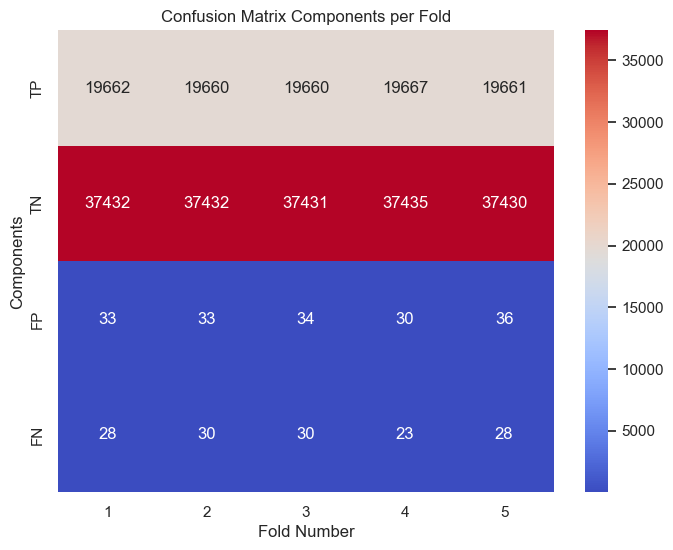

In [83]:
confusion_matrix_data = {
    'Fold': np.arange(1, 6),
    'TP': tp_list,
    'TN': tn_list,
    'FP': fp_list,
    'FN': fn_list
}

confusion_df = pd.DataFrame(confusion_matrix_data).set_index('Fold')

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df.T, annot=True, fmt=".0f", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix Components per Fold")
plt.ylabel("Components")
plt.xlabel("Fold Number")
plt.show()

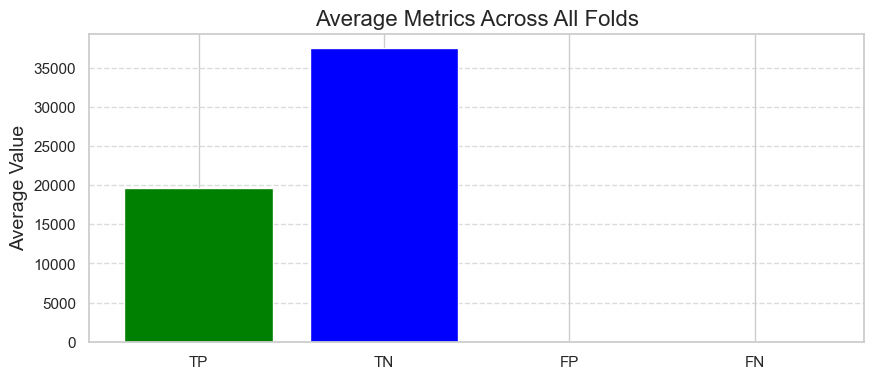

In [84]:
# Number of folds
folds = np.arange(1, 6)  # For 5 folds

# Create a dictionary of results for easier visualization
results = {
    "TP": tp_list,
    "TN": tn_list,
    "FP": fp_list,
    "FN": fn_list,
}

# Bar plot for average metrics
avg_metrics = [avg_tp, avg_tn, avg_fp, avg_fn]
metric_names = ["TP", "TN", "FP", "FN"]

plt.figure(figsize=(10, 4))
plt.bar(metric_names, avg_metrics, color=['green', 'blue', 'orange', 'red'])
plt.title("Average Metrics Across All Folds", fontsize=16)
plt.ylabel("Average Value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()